In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf

## EDA


In [2]:
# Fetch data from Yahoo Finance
df = yf.download(tickers='NVDA', start='2020-01-01')
df_xlk = yf.download(tickers='XLK', start='2020-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Finding correlation between NVDA and XLK ETF
fig, ax = plt.subplots()
ax.plot(df['Close'], color='purple', label='NVDA')
ax.set_xlabel('Date')
ax.set_ylabel('NVDA Price')
ax.legend(loc='upper left', borderpad=1, fontsize=6)

ax2 = ax.twinx()
ax2.plot(df_xlk['Close'], color='blue', label='XLK')
ax2.set_ylabel('XLK Price')
ax2.legend(loc='upper right', borderpad=1, fontsize=6)
plt.title('NVDA vs XLK Price')

## Prepare Data

### Log Returns 
$\ln(\frac{Current Price}{Original Price})$

Log returns measure the percentage change in value over time. This allows us to have a good gauge of the general direction of price.

### Index Funds
Index funds are indicators of the general performance of the sector. For this case, the SMA20 of [SPDR Technology Sector Fund (XLK)](https://finance.yahoo.com/quote/XLK?p=XLK) is used as a gauge for the performance of the tech industry as a whole.

In [3]:
# GLOBAL VARS
NUM_VARS = 7
TIMESTEPS = 20
DAYS_TO_PRED = 15

In [4]:
# Calculate SMA20 for XLK
df['xlk_SMA20'] = df_xlk['Adj Close'].rolling(20).mean()

# Calculate percentage changes
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())

# Drop Date and Close column
df.dropna(inplace=True)
#df.reset_index(inplace=True)
df.drop(['Close'], axis=1, inplace=True)

# Assign a final df for accessing later
output_df = df[TIMESTEPS:]


In [5]:
df

,Open,High,Low,Adj Close,Volume,xlk_SMA20,log_return
Date,,,,,,,
2020-01-30,60.402500,61.587502,59.849998,61.218681,29050400,92.081731,0.001099
2020-01-31,60.992500,61.112499,58.687500,58.882603,37042000,92.175274,-0.038907
2020-02-03,58.924999,60.277500,58.862499,59.853893,25556400,92.380200,0.016361
2020-02-04,61.507500,61.974998,61.005001,61.547432,27154400,92.696510,0.027902
2020-02-05,62.997501,63.099998,61.852501,62.451469,20822000,93.042715,0.014582
...,...,...,...,...,...,...,...
2023-10-13,469.600006,471.160004,452.799988,454.609985,47411500,166.300501,-0.032122
2023-10-16,450.630005,462.250000,449.119995,460.950012,37509900,166.345501,0.013850
2023-10-17,440.000000,447.540009,424.799988,439.380005,81233300,166.355502,-0.047925


In [6]:
# Define function to split data
def split(data):
    # DAYS_TO_PRED rows will be removed for test data, remaining split 80 20
    test_val_len = len(data) - DAYS_TO_PRED
    l_80 = int(test_val_len * 0.8)
    train_data, val_data, test_data = data[: l_80], data[l_80 : test_val_len], data[test_val_len :]
    return train_data, val_data, test_data

In [7]:
# Define function to create dataset with timesteps
def create_dataset(dataset, timesteps):
    x = []
    y = []
    for i in range(len(dataset) - timesteps):
        add_x = dataset[i : i + timesteps] # Slice from 0 - timesteps
        add_y = dataset[i + timesteps]

        # Extract vars
        add_x = [lst for lst in add_x]

        x.append(add_x)
        y.append(add_y)
    return np.array(x), np.array(y)

In [8]:
# Reshape array
#df = np.reshape(df, (-1, 1))

# Normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# Create datasets
X_full, y_full = create_dataset(df, TIMESTEPS)

# Split data
X_train, X_val, X_test = split(X_full)
y_train, y_val, y_test = split(y_full)

# Shape should be (samples, timesteps, features)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((722, 20, 7), (722, 7), (181, 20, 7), (181, 7), (15, 20, 7), (15, 7))

In [12]:
X_train[1]

array([[0.02425713, 0.01916477, 0.03041674, 0.02235921, 0.18847228,
        0.16629564, 0.39110529],
       [0.01968438, 0.01730993, 0.03081052, 0.02454402, 0.10904361,
        0.16834176, 0.52205012],
       [0.02539617, 0.02108069, 0.03563152, 0.02835342, 0.12009458,
        0.17149999, 0.5493936 ],
       [0.02869165, 0.02357971, 0.03753854, 0.03038695, 0.07630286,
        0.17495673, 0.51783491],
       [0.02877459, 0.0246071 , 0.03836548, 0.03234208, 0.08326262,
        0.17837495, 0.51603455],
       [0.02905105, 0.02420725, 0.03931618, 0.03085193, 0.06353132,
        0.18083991, 0.4583681 ],
       [0.02897364, 0.02946632, 0.04028938, 0.03722708, 0.29855874,
        0.18406074, 0.58810224],
       [0.0371681 , 0.03474204, 0.04733804, 0.03998332, 0.37390173,
        0.18654979, 0.52720546],
       [0.03865549, 0.03490864, 0.04937446, 0.04258823, 0.19139338,
        0.18978025, 0.52405895],
       [0.03876607, 0.03528628, 0.04974573, 0.04160231, 0.29745779,
        0.19282777, 0.4

In [13]:
y_train[0]

array([0.02342221, 0.03471982, 0.03437704, 0.04129502, 0.71600876,
       0.1895588 , 0.64173011])

### Stacked LSTM Implementation
Stacked LSTM allows us to process time series data.

In [9]:
# GLOBAL VARS
EPOCHS = 10
INPUT_SHAPE = (TIMESTEPS, NUM_VARS)
VALIDATION_SPLIT = 0.1

In [10]:
# Define model
model = keras.Sequential([

    keras.layers.LSTM(64, return_sequences=True, input_shape=INPUT_SHAPE, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64, return_sequences=True, activation='relu'),    
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(NUM_VARS, activation='linear')
    #keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

2023-10-20 00:37:11.551899: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-20 00:37:11.551928: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-20 00:37:11.551934: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-20 00:37:11.551973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-20 00:37:11.551992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            18432     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 20, 64)            4

In [11]:
# Train model
model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), batch_size=64)

Epoch 1/10


2023-10-20 00:37:16.163145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 32s 2s/step - loss: 0.1020 - val_loss: 0.1001
Epoch 2/10
12/12 [==============================] - 29s 2s/step - loss: 0.0250 - val_loss: 0.0639
Epoch 3/10
12/12 [==============================] - 30s 2s/step - loss: 0.0151 - val_loss: 0.0493
Epoch 4/10
12/12 [==============================] - 29s 2s/step - loss: 0.0125 - val_loss: 0.0388
Epoch 5/10
12/12 [==============================] - 30s 2s/step - loss: 0.0106 - val_loss: 0.0337
Epoch 6/10
12/12 [==============================] - 32s 3s/step - loss: 0.0093 - val_loss: 0.0348
Epoch 7/10
12/12 [==============================] - 29s 2s/step - loss: 0.0080 - val_loss: 0.0324
Epoch 8/10
12/12 [==============================] - 28s 2s/step - loss: 0.0073 - val_loss: 0.0335
Epoch 9/10
12/12 [==============================] - 28s 2s/step - loss: 0.0067 - val_loss: 0.0275
Epoch 10/10
12/12 [==============================] - 28s 2s/step - loss: 0.0065 - val_loss: 0.0286


In [12]:
# Prediction
train_predict = model.predict(X_train)
#test_predict = model.predict(X_test)

# Inverse transform to get original format
train_predict = np.reshape(train_predict, (-1, NUM_VARS))
#test_predict = np.reshape(test_predict, (-1, 1))
train_predict = scaler.inverse_transform(train_predict)
#test_predict = scaler.inverse_transform(test_predict)

23/23 [==============================] - 5s 180ms/step


In [13]:
y_train = scaler.inverse_transform(y_train)

In [14]:
# Extract close column out
train_predict = [lst[3] for lst in train_predict]
y_train = [lst[3] for lst in y_train]

In [16]:
train_results = pd.DataFrame(data={'Predictions': train_predict, 'Actual': y_train})

In [17]:
train_results

,Predictions,Actual
0,66.493828,67.300842
1,66.259926,68.885750
2,65.786194,66.259209
3,65.262726,70.899254
4,64.710464,68.103249
...,...,...
717,149.043121,143.099075
718,148.055725,147.437561
719,146.847809,142.599274
720,145.893555,148.537155


In [16]:
# Flatten data
# train_results = pd.DataFrame(data={'Predictions': train_predict.flatten(), 'Actual': y_train.flatten()})
# train_results

,Predictions,Actual
0,7.668041e+01,6.061500e+01
1,7.394013e+01,6.811500e+01
2,7.217123e+01,6.044750e+01
3,6.974403e+01,6.730083e+01
4,5.475013e+07,1.133252e+08
...,...,...
5049,1.560672e+02,1.514100e+02
5050,1.626500e+02,1.562244e+02
5051,4.303546e+07,5.042310e+07
5052,1.302924e+02,1.256526e+02


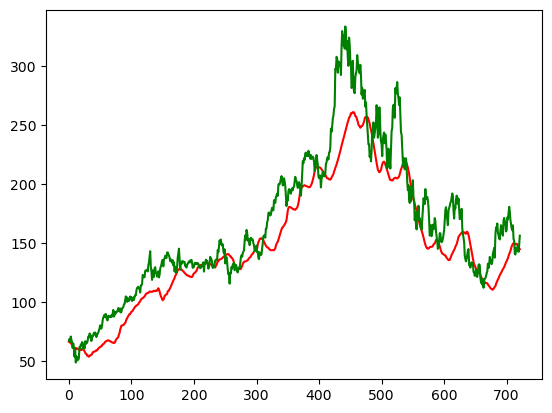

In [18]:
plt.plot(train_results['Predictions'], color = 'red')
plt.plot(train_results['Actual'], color = 'green')

In [19]:
# Calculate RMSE
train_rmse = mean_squared_error(y_train, train_predict, squared=False)

In [20]:
train_rmse

26.702095187008474

In [51]:
# Define function to take in number of days of predictions
def predict_y(days, data):
    # Normalise and reshape data
    data = scaler.fit_transform(data)
    data = data.reshape(-1, NUM_VARS)

    predictions = []
    
    for i in range(days):
        prediction = model.predict(data)
        predictions.append(prediction[0])

        # Remove first day
        data = data[0][1:]

        data = np.concatenate([df, prediction], axis=0)
    
    predictions = scaler.inverse_transform(data)
    predictions = pd.DataFrame(predictions)
    return predictions


In [52]:
predict_y(DAYS_TO_PRED, X_test)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [46]:
output_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-31,60.992500,61.112499,58.687500,59.107498,58.882599,37042000
2020-02-03,58.924999,60.277500,58.862499,60.082500,59.853897,25556400
2020-02-04,61.507500,61.974998,61.005001,61.782501,61.547432,27154400
2020-02-05,62.997501,63.099998,61.852501,62.689999,62.451469,20822000
2020-02-06,63.035000,63.562500,62.220001,63.562500,63.320648,21828400
...,...,...,...,...,...,...
2023-10-12,467.769989,476.089996,463.299988,469.450012,469.450012,48132500
2023-10-13,469.600006,471.160004,452.799988,454.609985,454.609985,47411500
2023-10-16,450.630005,462.250000,449.119995,460.950012,460.950012,37509900
